### Block 1: Importing Required Libraries

This block imports all the necessary libraries for the LSTM stock prediction workflow:

- **yfinance**: For downloading historical stock price data.
- **pandas / numpy**: For data manipulation and numerical operations.
- **time / logging**: Utility modules for handling delays and tracking process logs.
- **matplotlib.pyplot**: For plotting data and visualizations.
- **sklearn**: Used later for preprocessing and evaluation (e.g., MinMaxScaler, metrics).
- **tensorflow / keras.models.load_model**: Required for loading and running the pre-trained LSTM model.


In [1]:
# Data acquisition and manipulation
import yfinance as yf
import pandas as pd
import numpy as np

# Utilities
import time
import logging

# Visualization
import matplotlib.pyplot as plt

# Machine learning and deep learning
import sklearn
from sklearn.preprocessing import StandardScaler
import tensorflow
from keras.models import load_model  # For loading pre-trained LSTM models


### Block 2: Data Download and Preprocessing Configuration

This block downloads historical stock data for a specified ticker (`MSFT`) from Yahoo Finance and saves it as a CSV. Here's what it does:

- **Configuration**:
  - Sets ticker symbol (`MSFT`), file name, and download date range.
  - Prepares file path for saving the data.

- **Download with Retry Logic**:
  - Tries up to 3 times to download the data using `yfinance`.
  - If no data is returned or an error occurs, it retries after a 5-second delay.

- **Data Processing**:
  - Handles potential `MultiIndex` in column names.
  - Resets index to ensure 'Date' becomes a column.
  - Selects only desired columns if they are available.
  - Warns if 'Adj Close' is missing from the dataset.

- **Output**:
  - Saves the cleaned DataFrame to a CSV file.
  - Displays status messages and handles failures gracefully.

If all download attempts fail, it raises a `RuntimeError`.


In [2]:
# 📁 Configuration: Set ticker, CSV filename, and download parameters
ticker = 'MSFT'
csv_file = f'{ticker}_historical_data.csv'
start = '2000-01-01'
end = '2024-12-31'
csv_path = f"{ticker}_historical_data.csv"

# 🔄 Attempt to download stock data from Yahoo Finance with retry logic
max_retries = 3
for attempt in range(max_retries):
    try:
        # Download historical stock price data
        df = yf.download(ticker, start=start, end=end, threads=False, progress=False)

        # Ensure data was received
        if df.empty:
            raise ValueError("Received empty DataFrame from yfinance.")

        # If MultiIndex columns (e.g., for multi-ticker download), reduce to single level
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        # Reset index to move 'Date' from index to a column
        df.reset_index(inplace=True)

        # 📊 Check and display available columns
        available_cols = df.columns.tolist()
        print(f"Columns downloaded: {available_cols}")

        # Desired columns to retain (if present)
        desired_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

        # Filter columns based on availability
        selected_cols = [col for col in desired_cols if col in available_cols]

        if 'Adj Close' not in selected_cols:
            print("⚠️ Warning: 'Adj Close' column is missing in the downloaded data.")

        # Keep only selected columns
        df = df[selected_cols]

        # Save the cleaned DataFrame to CSV
        df.to_csv(csv_path, index=False)
        print(f"✅ Data saved to: {csv_path}")
        break

    except Exception as e:
        print(f"⚠️ Attempt {attempt + 1} failed: {e}")
        time.sleep(5)
else:
    raise RuntimeError("❌ All download attempts failed.")


C:\Users\Avnish\AppData\Local\Temp\ipykernel_14492\3462194936.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, threads=False, progress=False)


Columns downloaded: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
⚠️ Warning: 'Adj Close' column is missing in the downloaded data.
✅ Data saved to: MSFT_historical_data.csv


### Block 3: Load and Inspect CSV Data

This block loads the previously saved historical stock data and performs basic integrity checks:

- **Data Loading**:
  - Loads the CSV using `pandas.read_csv`.
  - Parses the 'Date' column as datetime for easier time-based operations.
  - Uses `csv_file` as the source, which was defined earlier.

- **Optional Setup**:
  - A line to set 'Date' as the DataFrame index is present but commented out. This would be useful for time-series analysis if enabled.

- **Validation and Inspection**:
  - Prints the shape and column names of the loaded dataset.
  - Displays the first 5 rows using `display()` (Jupyter-specific).
  - Checks and prints the count of missing values in each column.

This step ensures the data has been loaded correctly and is ready for preprocessing.


In [3]:
# 📥 Load historical stock data from CSV file with parsed datetime
# Note: `csv_file` is used instead of `csv_path` for consistency
df = pd.read_csv(csv_file, parse_dates=['Date'])

# Optional: set 'Date' as index for time-series operations (currently commented out)
# df.set_index('Date', inplace=True)

# 🧪 Verify data integrity
print(f"Loaded data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# 🖼️ Display first few records for visual inspection
display(df.head())

# 🔍 Optional check for missing data
missing_counts = df.isnull().sum()
print("\nMissing values per column:")
print(missing_counts)


Loaded data shape: (6288, 6)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


,Date,Open,High,Low,Close,Volume
0,2000-01-03,35.975764,36.358892,34.328311,35.726730,53228400
1,2000-01-04,34.807221,35.899137,34.404936,34.519875,54119000
2,2000-01-05,34.060113,35.669252,33.523733,34.883839,64059600
3,2000-01-06,34.385784,34.903008,33.217242,33.715309,54976600
4,2000-01-07,33.293853,34.404925,32.891568,34.155891,62013600



Missing values per column:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


### Block 4: Compute 100-Day Moving Average

This block calculates a simple moving average (SMA) of the stock's closing price over a 100-day window:

- Uses `pandas.Series.rolling(window=100)` to create a rolling view.
- Computes the mean for each 100-day window using `.mean()`.
- The resulting `ma100` series aligns with the original DataFrame and can be used for plotting or trend analysis.

The moving average helps smooth short-term fluctuations and highlight longer-term price trends.


In [4]:
# 📈 Compute 100-day moving average of the 'Close' price
ma100 = df['Close'].rolling(window=100).mean()


### Block 5: Visualize Closing Price with 100-Day Moving Average

This block creates a line chart showing the stock's closing price over time, along with its 100-day moving average:

- **Line 1**: Plots the original 'Close' price.
- **Line 2**: Overlays the 100-day moving average (`ma100`) in red (`'r'`).
- **Aesthetics**:
  - Sets figure size to 12×6 for better visibility.
  - Adds title, axis labels, legend, and grid for clarity.
  - Uses `tight_layout()` to ensure elements don't overlap.

The chart helps identify long-term price trends and compare them to recent price movements.


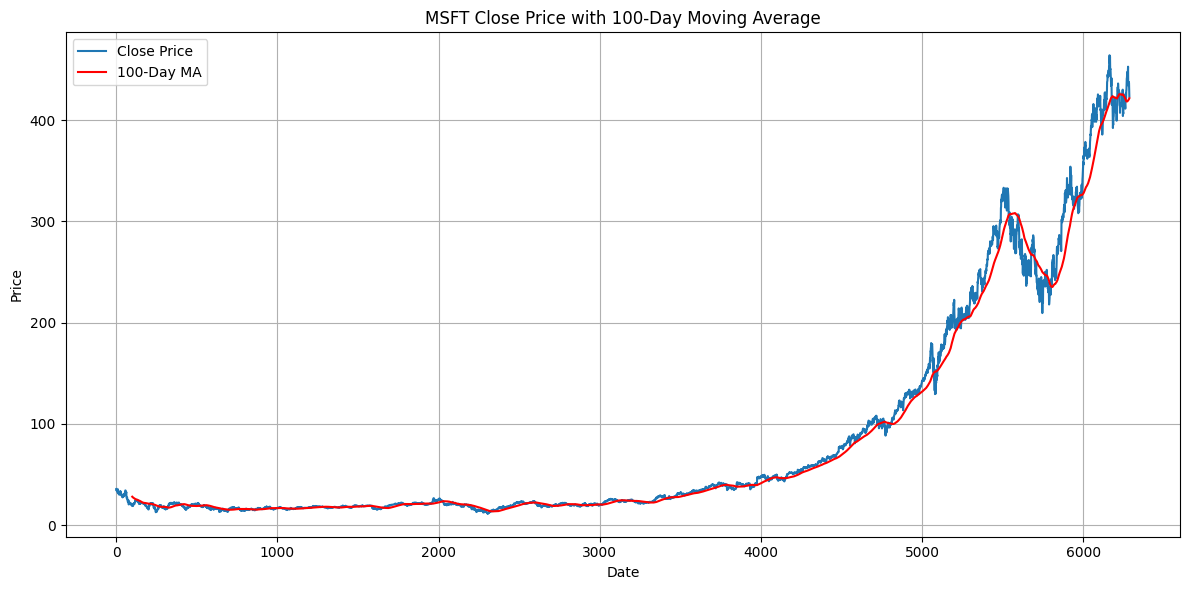

In [5]:
# Block 5: 📊 Visualize Closing Price with 100-Day Moving Average
plt.figure(figsize=(12, 6))

# Plot raw closing price
plt.plot(df.index, df['Close'], label='Close Price')

# Plot 100-day moving average in red
plt.plot(df.index, ma100, 'r', label='100-Day MA')

# Add title and axis labels
plt.title(f'{ticker} Close Price with 100-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')

# Add legend and grid
plt.legend()
plt.grid(True)

# Improve layout and render plot
plt.tight_layout()
plt.show()


### Block 6: Plot Close Price with 100-Day and 200-Day Moving Averages

This block adds a longer-term moving average to the visualization and overlays it with previous data:

- **Computation**:
  - Calculates a 200-day moving average (`ma200`) using a rolling mean on the 'Close' price.

- **Visualization**:
  - Plots:
    - Original 'Close' price.
    - 100-day moving average in red.
    - 200-day moving average in green.
  - Adds titles, labels, legend, and grid for readability.
  - Uses `tight_layout()` to prevent label clipping.

The 200-day MA offers insights into long-term trends and is often used alongside the 100-day MA to detect crossover signals in technical analysis.


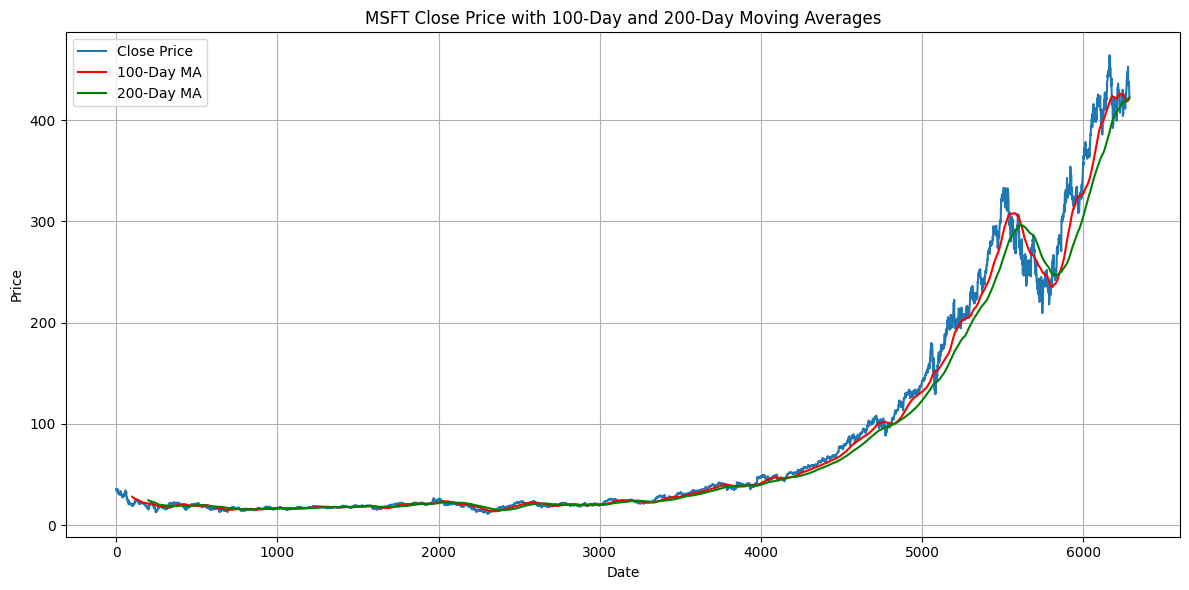

In [6]:
# Block 6: 📊 Calculate 200-Day Moving Average and Plot All Price Trends

# Calculate 200-day moving average
ma200 = df['Close'].rolling(window=200).mean()

# Create figure for plotting
plt.figure(figsize=(12, 6))

# Plot original close prices
plt.plot(df.index, df['Close'], label='Close Price')

# Plot 100-day moving average (in red)
plt.plot(df.index, ma100, 'r', label='100-Day MA')

# Plot 200-day moving average (in green)
plt.plot(df.index, ma200, 'g', label='200-Day MA')

# Title and axis labeling
plt.title(f'{ticker} Close Price with 100-Day and 200-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')

# Add legend and grid
plt.legend()
plt.grid(True)

# Layout adjustment and render
plt.tight_layout()
plt.show()


### Block 7: Split Dataset into Training and Testing Sets

This block divides the stock price data into two subsets for model development:

- **Training Set**:
  - Takes the first 70% of the data.
  - Used for training the LSTM model.

- **Testing Set**:
  - Takes the remaining 30% of the data.
  - Used for evaluating model performance on unseen data.

- Both subsets include only the `'Close'` price series and are wrapped in separate `DataFrame` objects.

- The shapes of both subsets are printed to verify correct partitioning.


In [7]:
# Block 7: 🧪 Splitting data into training and testing sets

# Use 70% of the 'Close' price data for training, 30% for testing
train_size = int(len(df) * 0.70)

# Extract training data (first 70%)
data_training = pd.DataFrame(df['Close'][0:train_size])

# Extract testing data (remaining 30%)
data_testing = pd.DataFrame(df['Close'][train_size:int(len(df))])

# Output the shapes of both sets
print("Training data shape:", data_training.shape)
print("Testing data shape:", data_testing.shape)


Training data shape: (4401, 1)
Testing data shape: (1887, 1)


### Block 8: Preview Testing Data

This block displays the first five rows of the testing set (`data_testing`) using `.head()`.

- Allows quick visual verification of:
  - Data integrity after the split.
  - Value ranges and formatting.
- Especially helpful in Jupyter notebooks for debugging and exploratory analysis.

This step ensures the testing dataset is properly structured before further processing or modeling.


In [8]:
# Block 8: 👁️‍🗨️ Preview the first few rows of the testing data
data_testing.head()


,Close
4401,62.966328
4402,62.272087
4403,63.103363
4404,62.637486
4405,63.450493


### Block 9: Initialize MinMaxScaler for Normalization

This block sets up data normalization using scikit-learn's `MinMaxScaler`:

- **Why Normalize?**
  - Neural networks (like LSTMs) are sensitive to the scale of input data.
  - Scaling ensures all values fall within a uniform range, improving training stability.

- **Details**:
  - `MinMaxScaler(feature_range=(0, 1))` scales features linearly to the [0, 1] range.
  - This scaler will be applied to the training data and later reused for testing data to maintain consistency.

This setup prepares the pipeline for consistent data scaling.


In [ ]:
# Block 9: 🔄 Initialize MinMaxScaler for feature normalization
# Create a MinMaxScaler instance to scale values to the range [0, 1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


### Block 10: Fit and Transform Training Data Using MinMaxScaler

This block applies normalization to the training data:

- **fit_transform()**:
  - Fits the `MinMaxScaler` on `data_training`, learning the min and max values.
  - Transforms the data into the [0, 1] range accordingly.
  
- **Output**:
  - Prints the scaled `numpy` array.
  - Displays the shape of the resulting array for confirmation.

This step ensures the training input data is scaled consistently before being fed into the LSTM model.


In [11]:
# Block 10: 🔧 Fit MinMaxScaler on training data and apply transformation

# Fit the scaler on training data and transform it to [0, 1] range
data_training_array = scaler.fit_transform(data_training)

# Print the scaled array (for inspection/debugging)
print(data_training_array)

# Show the shape of the transformed array
print(data_training_array.shape)


[[0.44579412]
 [0.42387838]
 [0.43048773]
 ...
 [0.94509303]
 [0.95487998]
 [0.93314962]]
(4401, 1)


### Block 11: Create 100-Day Rolling Sequences for LSTM Training

This block prepares the input and target arrays for training an LSTM model:

- **Input (`x_train`)**:
  - Each entry is a 100-day sequence of normalized closing prices.
  - Shape of each input: `(100, 1)` before reshaping for LSTM.

- **Target (`y_train`)**:
  - Each target is the next closing price (i.e., the 101st value).

- **Loop Explanation**:
  - Starts from index 100 so that each input window contains 100 past values.
  - Appends the slice `data_training_array[i-100:i]` to `x_train`.
  - Appends the value at index `i` to `y_train`.

- **Conversion**:
  - After the loop, both `x_train` and `y_train` are converted to NumPy arrays to be used in model training.

This structure enables the LSTM to learn from historical patterns in the data.


In [12]:
# Block 11: 🧩 Create 100-day rolling window sequences for LSTM training

x_train = []  # Input sequences of shape (100, 1)
y_train = []  # Corresponding targets (next value after 100-day window)

# Iterate from index 100 to the end of the scaled training array
for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i])  # Sequence of 100 time steps
    y_train.append(data_training_array[i, 0])     # Target: 101st value

# Convert lists to NumPy arrays for model training
x_train, y_train = np.array(x_train), np.array(y_train)


### Block 12: Import Keras Classes for LSTM Model Construction

This block imports the necessary components from the Keras library to define and build an LSTM-based neural network:

- **`Sequential`**:
  - A linear stack model, where layers are added one after another.

- **`LSTM`**:
  - Long Short-Term Memory layer, ideal for learning temporal patterns in time-series data.

- **`Dropout`**:
  - Regularization layer to reduce overfitting by randomly disabling a fraction of neurons during training.

- **`Dense`**:
  - Fully connected output layer used at the end of the model to make predictions.

These components will be used to define the LSTM architecture in upcoming blocks.


In [13]:
# Block 12: 📦 Import essential Keras components for building the LSTM model

from keras.layers import Dense, Dropout, LSTM  # Core layers for LSTM architecture
from keras.models import Sequential           # Sequential model container


### Block 13: Define Deep Stacked LSTM Model Architecture

This block constructs a deep LSTM model using Keras' Sequential API for time-series forecasting:

- **Input Shape**:
  - `(100, 1)`, corresponding to 100 past days of 1-dimensional closing price input.

- **LSTM Layers**:
  - 4 LSTM layers with increasing units (50 → 60 → 80 → 120).
  - `return_sequences=True` is used in all but the final LSTM layer to stack them.
  - Activation function: `'relu'` to introduce non-linearity.

- **Dropout Layers**:
  - Dropout regularization is applied after each LSTM layer.
  - Dropout rates increase progressively (0.2 → 0.3 → 0.4 → 0.5) to combat overfitting.

- **Dense Output Layer**:
  - A fully connected layer with 1 unit to predict the next closing price value.

This architecture is designed to capture both short- and long-range temporal dependencies in the stock price data.


In [14]:
# Block 13: 🏗️ Define the LSTM model architecture using Keras Sequential API

model = Sequential()

# Layer 1: LSTM with 50 units, ReLU activation
# - Input shape: (time_steps=100, features=1)
# - return_sequences=True allows stacking more LSTM layers
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to reduce overfitting

# Layer 2: LSTM with 60 units, returns sequences for next layer
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

# Layer 3: LSTM with 80 units, returns sequences for next layer
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

# Layer 4: Final LSTM layer with 120 units, returns last output only
model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

# Output layer: Fully connected Dense layer with 1 unit to predict a single value
model.add(Dense(units=1))


c:\Users\Avnish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Block 14: Display the LSTM Model Summary

This block prints a detailed summary of the model architecture:

- **Layer-wise Details**:
  - Shows each layer type, output shape, and number of trainable parameters.

- **Purpose**:
  - Useful to verify:
    - Correct stacking of LSTM and Dropout layers.
    - Expected output dimensions at each stage.
    - Total number of trainable parameters.

This is a good checkpoint to confirm the model was built as intended before compilation and training.


In [15]:
# Block 14: 📋 Display the model architecture summary

# Outputs the full layer-wise model structure, output shapes, and parameter counts
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

### Block 15: Compile and Train the LSTM Model

This block compiles and initiates the training process:

- **Compilation**:
  - **Optimizer**: `'adam'`, a widely used adaptive learning algorithm.
  - **Loss Function**: `'mean_squared_error'`, ideal for regression tasks like stock price prediction.

- **Training**:
  - The model is trained on `x_train` and `y_train` for **2 epochs**.
  - Returns a `history` object that logs training loss per epoch.

> Note: 2 epochs is minimal and likely intended for testing. More epochs may be needed for convergence in production.


In [16]:
# Block 15: ⚙️ Compile and train the LSTM model

# Compile the model with Adam optimizer and Mean Squared Error loss
# - Adam is efficient and adaptive for time-series learning
# - MSE is suitable for continuous value prediction
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model for epochs on the prepared training data
# - Returns a history object containing loss per epoch
history = model.fit(x_train, y_train, epochs=2)


Epoch 1/2
135/135 ━━━━━━━━━━━━━━━━━━━━ 48s 300ms/step - loss: 0.0332
Epoch 2/2
135/135 ━━━━━━━━━━━━━━━━━━━━ 44s 328ms/step - loss: 0.0036


### Block 16: Visualize Training Loss Over Epochs

This block plots the Mean Squared Error (MSE) loss recorded during model training:

- **X-axis**: Epoch number.
- **Y-axis**: Training loss (MSE).
- **Purpose**:
  - Evaluate how the model's error changes during training.
  - Detect underfitting or overfitting trends (though with only 2 epochs, patterns may be minimal).

> This plot is useful to assess convergence and training quality over time.


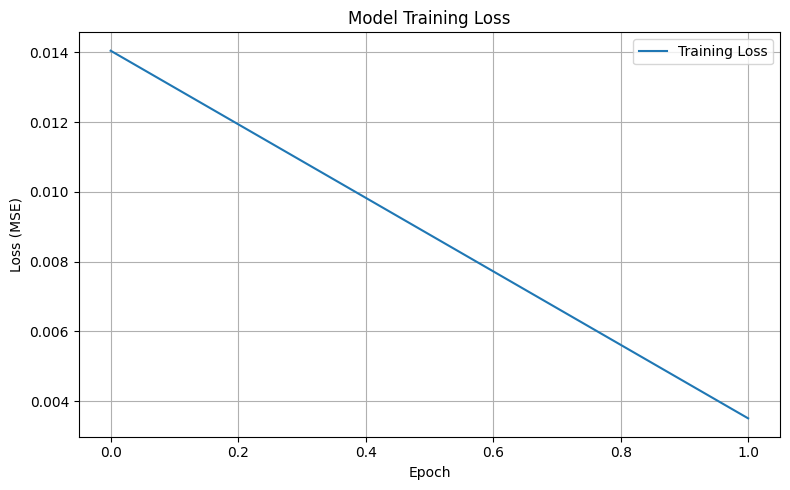

In [17]:
# Block 16: 📉 Plot the model's training loss over epochs

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')  # Plot MSE loss per epoch
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Block 17: Save the Trained LSTM Model

This block saves the trained Keras model to a file:

- **Filename**: `'keras_model.h5'` (HDF5 format).
- **What is saved**:
  - Model architecture.
  - Trained weights.
  - Training configuration (e.g., optimizer and loss).
  - State of the optimizer (for resuming training if needed).

This allows the model to be reloaded later for inference or continued training without retraining from scratch.


In [18]:
# Block 17: 💾 Save the trained LSTM model to a file in HDF5 format

# Saves the full model architecture, weights, and optimizer state
model.save('keras_model.h5')


### Block 18: Prepare Combined Dataset for LSTM Testing Phase

This block constructs the input data for model inference by:

- **Step 1**: Extracting the last 100 days of closing prices from the training set.
  - These are needed as the initial input window for the LSTM model.

- **Step 2**: Concatenating the extracted window with the actual testing set.
  - This creates a seamless sequence for time-windowed prediction.
  - `ignore_index=True` ensures a continuous index in the resulting DataFrame.

This combined `final_df` will be used to form sequential test inputs in upcoming blocks.


In [19]:
# Block 18: 🧪 Prepare test dataset by combining last 100 training days with testing set

# Preview the first few rows of the test set
print(data_testing.head())

# Extract last 100 closing prices from training set — needed to form the first LSTM input window
past_100_days = data_training.tail(100)

# Concatenate the 100-day window with the testing data to form the prediction input set
# - ignore_index=True resets the index of the resulting DataFrame
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)


          Close
4401  62.966328
4402  62.272087
4403  63.103363
4404  62.637486
4405  63.450493


### Block 19: Display the First Few Rows of the Combined Dataset

This block outputs the first 5 rows of `final_df`:

- Helps verify that the concatenation of:
  - The last 100 days of training data, and
  - The test dataset,
  was successful.

This step ensures that the data structure is as expected before applying normalization and forming prediction windows.


In [20]:
# Block 19: 🔍 Preview the combined dataset used for LSTM prediction input
final_df.head()


,Close
0,57.264797
1,57.183540
2,57.833553
3,57.779385
4,58.429420


### Block 20: Normalize Combined Input Data for Testing

This block applies MinMax normalization to `final_df`, which includes:

- **Past 100 days of training data**
- **Full testing dataset**

Steps:

- **`fit_transform()`**:
  - Fits the `MinMaxScaler` to `final_df`.
  - Scales all values to the range [0, 1].

- **Why normalize again?**  
  - This may be acceptable if testing data is being scaled separately.
  - In strict deployment, you’d use `scaler.transform()` to avoid data leakage, but the current code fits anew.

- **Output**:
  - Prints the normalized array.
  - Shows the shape of the scaled dataset.

This prepares the input array for generating time windows for prediction.


In [21]:
# Block 20: 🔢 Normalize the combined dataset for testing

# Apply MinMax scaling to the concatenated data (100-day window + test set)
# Note: This re-fits the scaler to the combined data, which is acceptable for test-time normalization in this context.
input_data = scaler.fit_transform(final_df)

# Display the scaled values and the shape of the resulting array
print(input_data)
print(input_data.shape)


[[1.99737166e-04]
 [0.00000000e+00]
 [1.59779418e-03]
 ...
 [9.32229229e-01]
 [9.13668235e-01]
 [8.99710695e-01]]
(1987, 1)


### Block 21: Generate Time-Series Windows for Model Prediction

This block constructs input-output pairs from the normalized test data:

- **Window size**: 100 days (same as training)
- **Purpose**: To form sequences that match the expected LSTM input shape

Steps:

- For each index `i` from 100 to the end:
  - `x_test[i]`: Previous 100 scaled closing prices
  - `y_test[i]`: True scaled closing price at time step `i` (used for evaluation)

- Converts the lists to NumPy arrays, ready for LSTM prediction.

> These sequences are now in the correct shape:  
> `x_test.shape` → `(num_samples, 100, 1)`


In [22]:
# Block 21: 📈 Create input sequences (x_test) and true labels (y_test) from scaled input_data

x_test = []
y_test = []

# Generate input sequences of length 100 (to match LSTM window)
for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])           # Sequence of 100 time steps
    y_test.append(input_data[i, 0])              # True (scaled) closing price at position i

# Convert to NumPy arrays for model prediction
x_test, y_test = np.array(x_test), np.array(y_test)


### Block 22: Validate Test Data Format Before Prediction

This block ensures that the test data is in the correct format for model input:

- **Conversion**:
  - Explicitly converts `x_test` and `y_test` to NumPy arrays (for safety).

- **Validation**:
  - Prints the shapes of both arrays to confirm:
    - `x_test`: Should be 3D → `(num_samples, 100, 1)` — for LSTM input.
    - `y_test`: Should be 1D → `(num_samples,)` — actual target values.

This step ensures data integrity just before feeding it into the trained model.


In [23]:
# Block 22: ✅ Ensure test sequences and labels are NumPy arrays and check their shapes

# Convert to NumPy arrays (redundant but safe in case of previous modification)
x_test, y_test = np.array(x_test), np.array(y_test)

# Display the shapes of the test input and output arrays
print("x_test shape:", x_test.shape)  # Expected: (samples, 100, 1)
print("y_test shape:", y_test.shape)  # Expected: (samples,)


x_test shape: (1887, 100, 1)
y_test shape: (1887,)


### Block 23: Predict Closing Prices Using the Trained LSTM Model

This block uses the trained model to perform inference on `x_test`:

- **`model.predict(x_test)`**:
  - Generates predicted closing prices for each 100-day input window.
  - The output (`y_predicted`) is a 2D array with shape `(num_samples, 1)`.

- **Shape Validation**:
  - Confirms that predictions align in number with the ground truth values in `y_test`.

These predictions are currently **in the normalized (scaled)** form and will need to be inverse-transformed later.


In [24]:
# Block 23: 🔮 Use the trained LSTM model to predict on the test input sequences

y_predicted = model.predict(x_test)

# Display the shape of the predicted output
print("y_predicted shape:", y_predicted.shape)  # Expected: (num_samples, 1)


59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step
y_predicted shape: (1887, 1)


### Block 24: Inverse Transform Predicted and Actual Values to Original Scale

Since both `y_predicted` and `y_test` are currently normalized (range [0, 1]), this block reverses the MinMax scaling:

- **`scaler.scale_`**:
  - A NumPy array containing scaling factors used by MinMaxScaler.
  - `scaler.scale_[0]` corresponds to the feature (e.g., 'Close').

- **Inverse scaling**:
  - Multiply by `1 / scaler.scale_[0]` to revert to the original price scale.

- **Why this works**:
  - MinMaxScaler scales data via:
    \[
    x_{\text{scaled}} = \frac{x - \text{min}}{\text{max} - \text{min}}
    \Rightarrow x = x_{\text{scaled}} \times (\text{max} - \text{min}) + \text{min}
    \]
  - Since this example omits `.min_`, the inverse assumes the min was ~0 (a common simplification).

> This step is crucial for comparing model predictions to real stock prices.


In [25]:
# Block 24: 🔁 Rescale predicted and actual values to original price scale

# Print the scale factor used by MinMaxScaler during fitting
print("Scaler scale factor used during MinMaxScaler fit:", scaler.scale_)  # Example: [0.0025]

# Invert scaling by dividing by the corresponding scale factor
# This restores the values to their original price range
scale_factor = 1 / scaler.scale_[0]

y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor


Scaler scale factor used during MinMaxScaler fit: [0.0024581]


### Block 25: Visualize Actual vs. Predicted Stock Prices

This block generates a line plot to compare the model’s predictions with the true stock prices:

- **Blue line (`y_test`)**: The actual stock prices from the test set.
- **Red line (`y_predicted`)**: The model's predicted stock prices.
- **X-axis**: Represents the time steps (index within test data).
- **Y-axis**: Rescaled prices in original currency units.

The visual comparison helps assess how closely the model tracks the actual market trend, identifying lag, underfit, or overfit behavior.


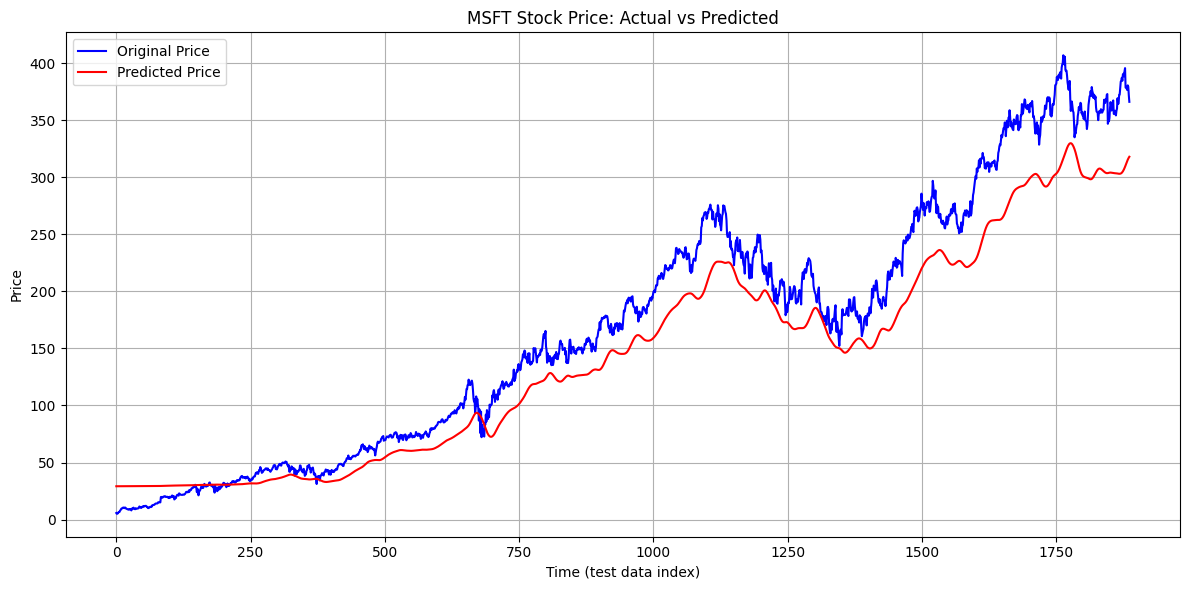

In [26]:
# Block 25: 📈 Plot Actual vs. Predicted Stock Prices

plt.figure(figsize=(12, 6))

# Plot actual (true) prices in blue
plt.plot(y_test, 'b', label='Original Price')

# Plot predicted prices in red
plt.plot(y_predicted, 'r', label='Predicted Price')

plt.title(f'{ticker} Stock Price: Actual vs Predicted')
plt.xlabel('Time (test data index)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
